In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from tqdm import tqdm
import seaborn as sns

import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import pandas as pd
from scipy.optimize import fsolve

N = 20001

fname = f'Jaffe_{N-1}_eps_0.01_out_perturber_Mp_0.03.txt'

In [3]:
G = 1 

# Masse
M   = 1 
M_p = M / 30
m   = M / N

# Raggi
Rs   = 1 

# Rho0
rho_0 = M / (4 * np.pi * (Rs)**3)

In [4]:
data = pd.read_csv(fname, names=list(range(7)), sep = ' ')
datas = np.array(data)

In [5]:
def dati (data,N,M_tot,M_p):

    x = []
    y = []
    z = []
    
    v_x = []
    v_y = []
    v_z = []
    
    start = N + 3
    step  = N * 3 + 3
    
    a = (np.array([data.iloc[i::step,:].copy() for i in range(start,start+N)]))
    for j in range(len(a)):
        temp = np.array([a[j][i][~np.isnan(a[j][i])] for i in range(len(a[j]))])
        
        x.append(temp[:,0])
        y.append(temp[:,1])
        z.append(temp[:,2])
        
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)
    
    
    b = (np.array([data.iloc[i::step,:].copy() for i in range(start+N,start+(N)*2)]))
    
    for j in range(len(b)):
        temp = np.array([b[j][i][~np.isnan(b[j][i])] for i in range(len(b[j]))])
        
        v_x.append(temp[:,0])
        v_y.append(temp[:,1])
        v_z.append(temp[:,2])
     

    v_x = np.array(v_x)
    v_y = np.array(v_y)
    v_z = np.array(v_z)
    
    #cm
    cm_x = []
    cm_y = []
    cm_z = []
    
    # Centro di Massa del sistema di 20000 particelle uso mean e median
    cm_x.append(np.median(x[1:], axis=0))
    cm_y.append(np.median(y[1:], axis=0))
    cm_z.append(np.median(z[1:], axis=0))

    cm_x = np.array(cm_x[0])
    cm_y = np.array(cm_y[0])
    cm_z = np.array(cm_z[0])

    print('The initial center of mass is (', cm_x[0],', ', cm_y[0],', ', cm_z[0], ')')  
    print('The final center of mass is (', cm_x[-1],', ', cm_y[-1],', ', cm_z[-1], ')')
            
    cm_v_x = []
    cm_v_y = []
    cm_v_z = []        
        
    # Velocità del centro di massa Jaffe
    cm_v_x.append(np.median(v_x[1:], axis=0))
    cm_v_y.append(np.median(v_y[1:], axis=0))
    cm_v_z.append(np.median(v_z[1:], axis=0))

    cm_v_x = np.array(cm_v_x[0])
    cm_v_y = np.array(cm_v_y[0])
    cm_v_z = np.array(cm_v_z[0])
        
    
    r    = np.array([(x[i]**2+y[i]**2+z[i]**2)**0.5 for i in range(N)])
    cm_r = np.array([(cm_x[i]**2+cm_y[i]**2+cm_z[i]**2)**0.5 for i in range(len(cm_x))])
    
    
    t = (np.array(data.iloc[2::step,:].copy()))[:,2]
    
    return x,y,z,cm_x, cm_y, cm_z,v_x,v_y,v_z,cm_v_x,cm_v_y,cm_v_z,r,cm_r,t

In [6]:
x,y,z,cm_x,cm_y,cm_z,v_x,v_y,v_z,cm_vx,cm_vy,cm_vz,r,r_cm,time = dati(data, N, M, M_p)

The initial center of mass is ( -0.0015768655 ,  -0.00026716299 ,  -0.0015464216999999999 )
The final center of mass is ( 0.47059594 ,  2.1029947 ,  -0.0030345974999999997 )


In [15]:
x      = x[:, :200]
y      = y[:, :200]
z      = z[:, :200]
cm_x   = cm_x[:200]
cm_y   = cm_y[:200]
cm_z   = cm_z[:200]
v_x    = v_x[:, :200]
v_y    = v_y[:, :200]
v_z    = v_z[:, :200]
cm_vx  = cm_vx[:200]
cm_vy  = cm_vy[:200]
cm_vz  = cm_vz[:200]
r      = r[:, :200]
r_cm   = r_cm[:200]
time   = time[:200]

In [16]:
perturber_position = np.matrix(np.empty((len(time), 3)))
perturber_velocity = np.matrix(np.empty((len(time), 3)))

for i in range(len(time)):
    # Posizioni sono in kpc
    perturber_position[i, 0] = x[0][i] - cm_x[i]
    perturber_position[i, 1] = y[0][i] - cm_y[i]
    perturber_position[i, 2] = z[0][i] - cm_z[i]

    #Velocità sono in cm/s
    perturber_velocity[i, 0] = v_x[0][i] - cm_vx[i]
    perturber_velocity[i, 1] = v_y[0][i] - cm_vy[i]
    perturber_velocity[i, 2] = v_z[0][i] - cm_vz[i]

$$
    e = \sqrt{1 + \frac{2 \varepsilon h^2}{\mu^2}}
$$

dove $\varepsilon = v^2 / 2 - \mu / r$ e $\vec{h} = \vec{r} \times \vec{v}$

In [203]:
distance = np.sqrt((cm_x - x[0])**2 + (cm_y - y[0])**2 + (cm_z - z[0])**2)

In [18]:
eps = np.zeros(len(time))
h = []
# Creo il vettore h a ogni tempo come prodotto vettoriale tra la posizione e la velocità del perturber a quel tempo
for i in range(len(time)):
    eps[i] = np.dot(perturber_velocity[i].A[0], perturber_velocity[i].A[0])/2 - (G*(M+M_p))/(distance[i])
    #distance[i] è la distanza del perturber dal centro di massa (calcolata su)
    h.append(np.cross(perturber_position[i].A[0], perturber_velocity[i].A[0]))

# Calcolo h^2 facendo la norma quadro (prodotto scalare con se stesso di h) a ogni tempo
h = np.array(h)
h2 = np.zeros(len(h))
for i in range(len(h)):
    h2[i] = np.dot(h[i], h[i])

eccentricity1 = np.sqrt(1 + 2*eps*h2 / ((G*(M+M_p))**2))

In [20]:
# Set Seaborn style
sns.set(style='whitegrid')

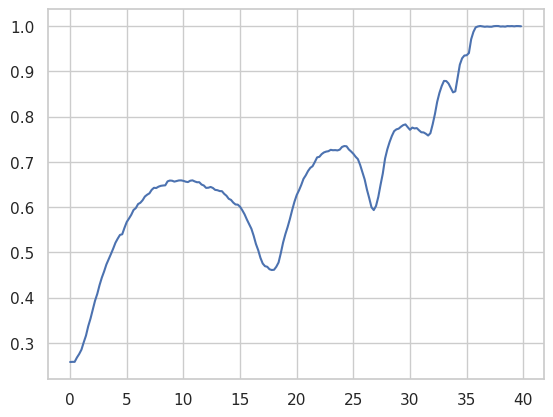

In [21]:
plt.plot(time, eccentricity1)

### Modo 2

Calcolo il momento angolare specifico $\vec{h} = \vec{r} \times \vec{v}$ dove $\vec{r}$ è il vettore posizione e $\vec{v}$ il vettore velocità del perturber. Dopodiché calcolo il vettore eccentricità come:

$$
    \vec{e} = \frac{\vec{v} \times \vec{h}}{\mu} - \frac{\vec{r}}{r}
$$

dove $\mu = G(=1) (M_{in} + M_p)$

In [22]:
# Find M_inside
M_in = np.zeros(len(time))
for i in range(len(time)):
    count = 0
    for j in range(1, N):
        if np.sqrt((x[j][i]-cm_x[i])**2 + (y[j][i]- cm_y[i])**2 + (z[j][i]-cm_z[i])**2) < distance[i]:
            count +=1
    M_in[i] = count*m

In [26]:
ecc = np.matrix(np.empty((len(time), 3)))
for i in range(len(time)):
    ecc[i].A[0] = np.cross(perturber_velocity[i], h[i])/(G*(M_p + M)) - (perturber_position[i].A[0])/np.linalg.norm(perturber_position[i].A[0])

ecc_mag = np.zeros(len(time))
for i in range(len(time)):
    ecc_mag[i] = np.linalg.norm(ecc[i]) 

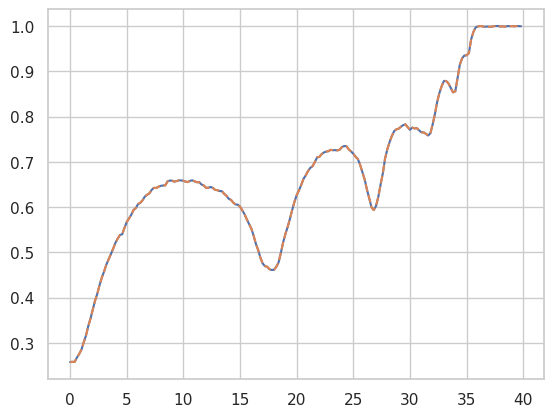

In [32]:
plt.plot(time, eccentricity1)
plt.plot(time, ecc_mag, linestyle='--')

### Apo e peri

In [212]:
perturber_velocity[1].A[0]

array([-5.66903479e-02,  7.12585657e-01, -2.04691165e-04])

In [168]:
def Jaffe_pot(radii, Rs, M, G):
    return (M * G) / Rs * np.log(radii/(radii+Rs)) 

def V_cent(radii, Rs, M, G, indice):
    mp_v = M_p * perturber_velocity[indice].A[0]
    L0 = np.cross(perturber_position[indice].A[0], mp_v)
    L02 = np.linalg.norm(L0)**2

    return L02/(2 * M_p * radii**2)

def Phi_eff(radii, Rs, M_p, G, indice):
    return Jaffe_pot(radii, Rs, M, G) + V_cent(radii, Rs, M, G, indice)

def equation(radii, Rs, M_p, G, indice, E):
    return Phi_eff(radii, Rs, M_p, G, indice) - E

In [169]:
velocities = np.sqrt(v_x**2 + v_y**2 + v_z**2)

In [260]:
ecc_rays = np.linspace(0, 10, 1000)

In [274]:
eccentricita_2 = np.zeros(len(time))
for i in range(0, len(time)):
    E_p = 0.5 * M_p * velocities[0][i]**2 + Jaffe_pot(distance[i], Rs, M, G)
    r_initial_guesses = [0.002, 3]
    r_solution = fsolve(equation, r_initial_guesses, args=(Rs, M_p, G, i, E_p))
    r_peri = r_solution[0]
    r_apo =  r_solution[1]

    eccentricita_2[i] = (r_apo - r_peri)/(r_apo+r_peri)

/tmp/ipykernel_327748/2698372355.py:2: RuntimeWarning: invalid value encountered in log
  return (M * G) / Rs * np.log(radii/(radii+Rs))


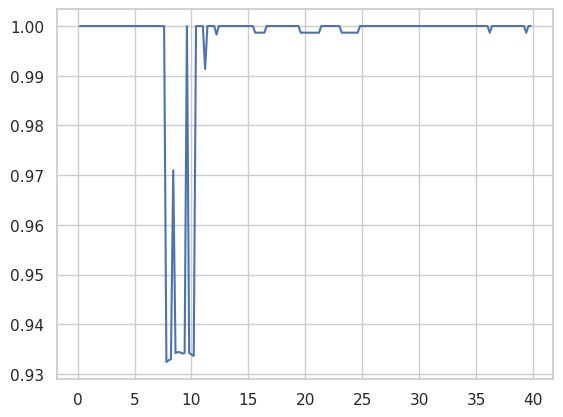

In [275]:
plt.plot(time[1:], eccentricita_2[1:])

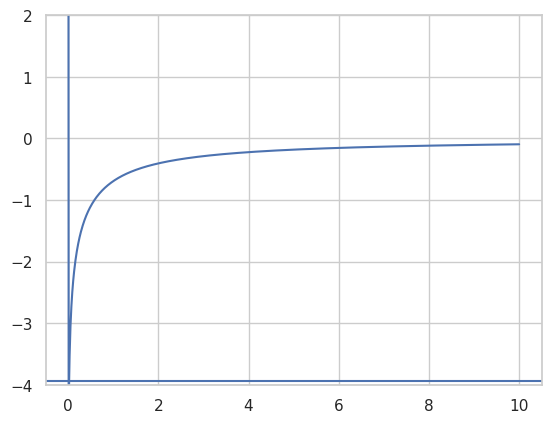

In [245]:
i = 199
plt.plot(ecc_rays, Phi_eff(ecc_rays, Rs, M_p, G, i))
plt.ylim(-4, 2)
plt.axhline(y = 0.5 * M_p * velocities[0][i]**2 + Jaffe_pot(distance[i], Rs, M, G))